<a href="https://colab.research.google.com/github/Otavio8888/macroeconometric/blob/main/acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mercado de Ações
## Mercado Financeiro e Gestão de Portfólios

À medida que a economia se expande, mais relevante se apresenta o sistema de distribuição de valores mobiliários como fator multiplicador da riqueza nacional.^[Essa seção está baseada em @assafneto]

Vejamos, por exemplo, a relação entre o `Índice Bovespa` e o `crescimento da Formação Bruta de Capital Fixo (FBCF)` no Brasil.

## Ibovespa x FBCP

In [1]:
# @title Texto de título padrão
!pip install sidrapy --quiet

In [2]:
# @title Texto de título padrão
import yfinance as yf # coleta de dados do yahoo finance
import sidrapy # coleta os dados do sidra

import pandas as pd # manipulação de dados
import numpy as np # cálculo e manipulação de dados
import matplotlib.pyplot as plt # visualização
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# @title Texto de título padrão
# Ibovespa (^BVSP) - Pontos - Fonte: Yahoo Finance
ibov = yf.download('^BVSP', start = '2001-01-01', progress = False, auto_adjust = False)[['Close']]

# Tratamento
ibovespa = (
          ibov
          .interpolate(method = 'linear')  # Interpolação linear dos valores faltantes
          # Transforma em dados trimestrais
          .resample('QE') # frequência trimestral (quartely)
          .last() # última data/valor do trimestre
          .assign(date = lambda x : pd.PeriodIndex(x.index, freq = 'Q')) # altera o tipo de dado da data - formato YYYYQ
          .set_index('date') # coloca a data no índice
          # renomeia as colunas
          .rename(columns = {'Close' : 'ibovespa'})
          )

ibovespa.columns = ibovespa.columns.droplevel(1)

/tmp/ipython-input-2412045163.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = lambda x: pd.to_datetime(x['date'].dt.strftime('%m-%Y')))


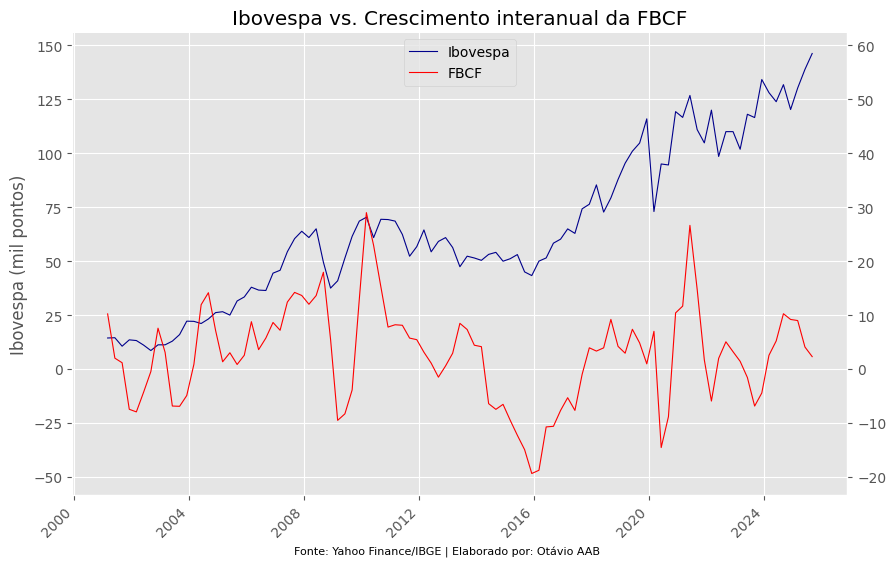

In [4]:
# @title Texto de título padrão
# Tabela 1620 - Contas nacionais Trimestrais - Série encadeada do índice de volume trimestral (Base: média 1995 = 100) - Fonte: SIDRA
## Formação Bruta de Capital Físico - API: /t/1620/n1/all/v/all/p/all/c11255/93406/d/v583%202"

fbcf = sidrapy.get_table(table_code = '1620', # número da tabela
                         territorial_level = "1", # nível territorial
                         ibge_territorial_code = "all", # código ibge
                         classifications = {'11255': '93406'}, # classificação (FBCF)
                         period = "all", # período
                         header = 'n'  # cabeçalho
                         )

# Tratamento do DF fbcf e cálculo da variação
dfbcf = (
    fbcf
    [['D2C', 'V']] # seleciona colunas
    # renomeia as colunas
    .rename(columns = {'V': 'fbcf',
                       'D2C': 'date'}
            )
    .assign(
        # substitui o 5º caracter da coluna data por "-Q" e converte em YYYYQ
        date = lambda x: pd.PeriodIndex(
            x.date.str.slice_replace(start = 4, stop = 5, repl = "-Q"), freq = 'Q'
            ),
        # altera as colunas para float e calcula a variação interanual
        dfbcf = lambda x: ((x['fbcf'].astype(float) / x['fbcf'].astype(float).shift(4)) - 1) * 100
    )
    .set_index('date') # coloca a data no índice
    [['dfbcf']] # seleciona a série de variação
)

# Junta os dados em um df
dados = dfbcf.merge(ibovespa, how = 'inner', left_index = True, right_index = True)


# Tratamento para a visualização
dados_grafico = (
                 dados
                .reset_index()
                .assign(ibovespa = lambda x: x.ibovespa / 1000,
                        date = lambda x: pd.to_datetime(x['date'].dt.strftime('%m-%Y')))
                )

plt.style.use('ggplot')

# Visualização
plt.figure(figsize=(10, 6))
plt.plot(dados_grafico['date'], dados_grafico['ibovespa'], color='darkblue', label='Ibovespa', linewidth=0.8)
plt.plot(dados_grafico['date'], dados_grafico['dfbcf'] * 2.5, color='red', label='FBCF', linewidth=0.8)
plt.ylabel('Ibovespa (mil pontos)')
plt.xlabel('')
plt.title('Ibovespa vs. Crescimento interanual da FBCF')
plt.legend(loc='upper center')
plt.xticks(rotation=45, ha='right')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().secondary_yaxis('right', functions = (lambda x: x / 2.5, lambda x: x * 2.5))
plt.figtext(0.5, 0.01, 'Fonte: Yahoo Finance/IBGE | Elaborado por: Otávio AAB', ha = 'center', fontsize=8)
plt.show()

## Introdução

As empresas têm diversas alternativas de financiamento:

- Empréstimos
- Reinvestimento de lucros
- Aporte de capital de acionistas

Tradicionalmente, no Brasil, o mercado de crédito ainda é a última opção de financiamento das empresas. **A despeito do franco crescimento dos últimos anos**.

A função básica do mercado de capitais é a de promover a riqueza nacional por meio da participação da poupança de cada agente econômico. Nesse mercado, os principais ativos negociados são as **ações**, representativos do capital das empresas.

## Mercado Primário e Secundário de Ações

Uma distinção inicial importante refere-se ao *mercado primário* e ao *mercado secundário*.

No mercado primário, os **novos** valores mobiliários são negociados diretamente entre a empresa emissora e os investidores.

Significa dizer que o valor arrecadado vai para a empresa, que utilizam os recursos para, por exemplo, financiar projetos de investimento. É uma alternativa para captação de recursos.

Importante dizer que: todas as emissões de títulos/valores no mercado primário precisam ser autorizadas pela CVM.

Quando uma empresa realiza a **oferta pública** de ações pela primeira vez, a operação recebe o nome de *Initial Public Offer (IPO)*. As demais ofertas de ações que surgem a partir dessa são chamadas de *follow on* ou ofertas subsequentes.

Também pode ocorrer o inverso, chamada de oferta pública de aquisição de ações (OPA) quando a empresa quer reduzir a dispersão de acionistas ou fechar o capital.

Ao contrário do mercado primário, no **mercado secundário** há apenas uma troca da propriedade dos papéis. O dinheiro não vai mais para a empresa.

A função principal do mercado secundário é o de prover liquidez aos títulos já que concentra a compra e venda de ações já emitidas. No mercado secundário ocorre somente uma transferência de propriedade dos papéis.

Investidores emitem uma ordem de compra ou venda de determinada ação a uma *Corretora de Valores*, as responsáveis por executar essa ordem no **pregão eletrônico** da Bolsa de Valores.

## Características das ações

**Ações** são títulos representativos da menor fração do capital social de uma empresa. Assim, o acionista se constitui em um *coproprietário* da empresa, com direito a participação em seus resultados.

As ações podem ser **ordinárias**, com direito a voto em assembléias que decidem o rumo da empresa, ou **preferenciais**, sem direito a voto, mas com preferência no recebimento de dividendos, por exemplo.

O **preço de mercado** é formado no pregão da bolsa, como resultado da oferta e procura de cada papel.

As ações são títulos de renda variável, que oferecem ganhos ou perdas ao investidor baseados no comportamento de seus preços de mercado.

Há duas formas básicas de rendimento: dividendos e valorização de preço de mercado.

Os **dividendos** representam uma distribuição de lucros auferidos pela empresa aos seus acionistas.

Empresas podem distribuir mais ou menos lucros. Por exemplo: podem reinvestir os lucros de um período ou ao invés de distribuir para os acionistas.

Ações também podem ser mais ou menos *líquidas*. Isto é, mais ou menos fáceis de serem vendidas/compradas no mercado.

Ações ***blue chips** são consideradas ações com mais liquidez.

Ações de 2ª linha possuem menor liquidez em relação às blue chips.

Já as **small caps** são ações de baixa liquidez, em geral pertencentes a empresas de menor porte.

### Códigos (tickers)

Ticker é um código usado na bolsa de valores para identificar e negociar um determinado ativo. É formado pela abreviação do nome do ativo, em 4 letra com a adição de 1 número, representando o tipo ativo. Os números mais utilizados são: 3 para ações ordinárias, 4 para ações preferênciais e 11 para BDRs, Fundos Imobiliários, ETFs e Units.

### OHCL

Dados de preços de ações são disponbilizadas e acompanhadas, por Open, High, Low e Close. Há a ainda a adição de Volume e Adjusted Close.

Vejamos um exemplo para as ações preferênciais da Petrobras, como ticker PETR4.

obs. o parâmetros `multi_level_index = False` evita retornar um dataframe com multi-índices, tornando a análise dificultosa.

In [5]:
# Define o ticker
ticker = 'PETR4.SA'

# Pega os dados
data = yf.download('PETR4.SA', start = "2016-01-01", multi_level_index=False)

/tmp/ipython-input-3112757978.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('PETR4.SA', start = "2016-01-01", multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


A periodicidade padrão é diária. Para escolher outras periodicidades de preços, utiliza-se o argumento `period`. Dentre as escolhas, temos:

 - Diário: "1d"

 - Semanal: "1wk"

 - Mensal: "1mo"

Exemplo:

In [6]:
# Pega os dados
yf.download(ticker, start = "2016-01-01", period = "1mo", multi_level_index=False).head()

/tmp/ipython-input-2874224977.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker, start = "2016-01-01", period = "1mo", multi_level_index=False).head()
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,1.830891,1.873532,1.745609,1.750940,45962100
2016-01-05,1.780256,1.865537,1.764265,1.844217,29446700
2016-01-06,1.705634,1.742945,1.705634,1.740280,67507200
2016-01-07,1.668323,1.713629,1.620352,1.649668,57387900
2016-01-08,1.670988,1.718959,1.633678,1.700304,52100300


### Gráfico de Candlestick

Uma forma interessante de analisar os preços de uma ação é através de um gráfico de CandleStick (ou OHLC), que permite visualizar os preços de abertura, máximo, mínimo e fechamento. Vejamos como construir usando o Python, tomando como base as ações diárias da PETR4:

In [7]:
# Crie um gráfico de candlestick
fig = go.Figure(data =
                [go.Candlestick(
                x = data.index,
                open = data['Open'],
                high = data['High'],
                low = data['Low'],
                close = data['Close'])
               ]
              )

# Personalize o layout do gráfico
fig.update_layout(
    title = 'Gráfico de Candlestick PETR4.SA',
    xaxis_title = 'Data',
    yaxis_title = 'Preço',
    xaxis_rangeslider_visible = True  # Adicionar controle deslizante de zoom
  )

### Dividendos

Como mencionado anteriormente, empresas distribuem parte do lucro para os seus acionistas, parte dessa distribuição é relacionada aos dividendos recebidos por dentendores da ação. Vejamos como analisar os dividendos usando o Python:

In [8]:
# Instância a classe do ticker
dados = yf.Ticker(ticker)

# Usa o atributo para salvar os dados do ticker
dividendos = dados.dividends

Vamos realizar uma simples análise, de forma a agregar os valores de dividendos da empresa por ano:

In [9]:
anual_dividendos = (
    pd.DataFrame(dividendos) # transforma em df
    .tz_localize(None) # retira o timezone da data
    .assign(Year = lambda x: x.index.year) # cria uma coluna do ano inteiro
    .groupby(['Year']) # agrupa por ano
    .agg({'Dividends' : 'sum'}) # soma os dividendos do ano
)

anual_dividendos

,Dividends
Year,
2005,0.250663
2006,0.759750
2007,0.913500
2008,0.257900
2009,1.051600
2010,0.993300
2011,0.920820
2012,0.501700
2013,0.780000


<Axes: xlabel='Year'>

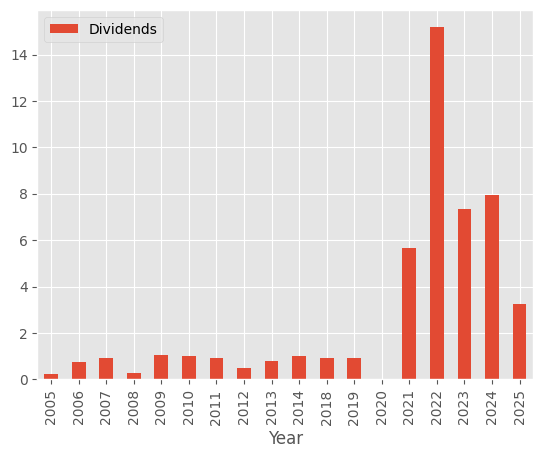

In [10]:
anual_dividendos.plot(kind = "bar")

# Índices de Bolsa de Valores

O `Índice de Bolsa de Valores` é um valor que mede o desempenho médio dos preços de uma suposta carteira de ações, refletindo assim o comportamento do mercado ao longo do tempo.

O `Ìndice da Bolsa de Valores de São Paulo` é o mais importante indicador do desempenho das cotações das ações negociadas no mercado brasileiro. O Ibovespa foi criado em 1968, a partir de uma carteira teórica de ações, expressa em pontos, com valor inicial de 100 pontos.

O valor em pontos publicado pelo Ibovespa é determinado pelo produto da quantidade de cada ação que compõe sua carteira técnica, e o seu respectivo preço de mercado.

O Ibov considera em sua carteira teórica apenas as ações com o maior grau de negociabilidade.

### Dados do Ibov

Vejamos como obter dados do Ibovespa:

In [11]:
# Ibovespa (^BVSP) - Pontos - Fonte: Yahoo Finance
ibov = yf.download('^BVSP', start = '2001-01-01', progress = False, auto_adjust = False)[['Adj Close']]

Podemos analisar por meio de um gráfico:

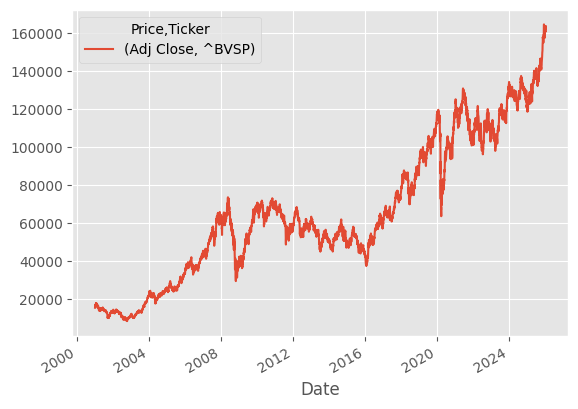

In [12]:
ibov.plot();